In [1]:
from ast import Del
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import maturity_payoff,calculate_option_price
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data,extract_current_price
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import estimate_IV
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

## No Variance Reduction Simulation

In [2]:
experiment_details = {
    'Nsim': 250,
    'latest_price_date': '2022-10-24',
    'variance_reduction': 'NULL',
    'GBM': 'multivariate',
    'r': 0.045,
    'min_sigma':0.0001,
    'max_sigma':0.1,
    'error':0.000001
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

# def EMS(SimPaths,Deltat,r):
#     Nsim,m = SimPaths.shape
#     m-=1
#     S = np.zeros((Nsim,m+1))
#     Z = np.zeros((Nsim+1,m))
#     # print(SimPaths[:,0:1])
#     S[:,0:1] = SimPaths[:,0:1]
#     # print(S[:,0:1])


#     for j in range(1,m+1):
#         Z[0:Nsim,j-1:j] = S[:,j-1:j]*SimPaths[:,j:j+1]/SimPaths[:,j-1:j]
#         Z[Nsim:Nsim+1,j-1:j]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[0:Nsim,j-1:j])
#         S[:,j:j+1] = SimPaths[:,0:1]*Z[0:Nsim,j-1:j]/Z[Nsim:Nsim+1,j-1:j]
#     # print(S)
#     return S


date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

# Used later to estimate Implied Volatility
min_sigma = experiment_details['min_sigma']
max_sigma = experiment_details['max_sigma']
error = experiment_details['error']
sigma_hat_list = np.arange(min_sigma,max_sigma+error,error)
right = len(sigma_hat_list)
left = 0 

predicted_option_price = []
expected_payoff_maturity = []
# counter = 0

while date_to_predict <= end_date:
    # if counter == 5:
    #     break

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    rho = np.corrcoef(AAGlogreturns, rowvar=False)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']
    print(f"trading_days_to_simulate: {trading_days_to_simulate}")
    # print(f"m: {m}")

    aapl_current_price = extract_current_price('../data/24-10-2022/aapl.csv',date_to_predict)
    amzn_current_price = extract_current_price('../data/24-10-2022/amzn.csv',date_to_predict)
    googl_current_price = extract_current_price('../data/24-10-2022/googl.csv',date_to_predict)

    if aapl_call_option_df['Closing Price'].isnull().all():
        #No option traded on this day, unable to backcalculate the IV for this day --> Use historical vol
        aapl_sigma_hat = np.cov(AAGlogreturns,rowvar=False)[0][0]
    else:
        # There exist at least one option traded on this day, we take the average IV of all option traded on this day
        aapl_call_option_list = aapl_call_option_df[aapl_call_option_df['Date']==date_to_predict].values.tolist()
        aapl_IV_list = []
        for row in aapl_call_option_list:
            aapl_K = row[-2]
            aapl_C_mkt = row[-1]            
            aapl_IV_list.append(estimate_IV(aapl_C_mkt,aapl_current_price,aapl_K,r,alternative_option_ttm,sigma_hat_list,left,right,error))
        aapl_sigma_hat = np.mean(aapl_IV_list)
    
    if amzn_call_option_df['Closing Price'].isnull().all():
        #No option traded on this day, unable to backcalculate the IV for this day --> Use historical vol
        amzn_sigma_hat = np.cov(AAGlogreturns,rowvar=False)[1][1]

    else:
        # There exist at least one option traded on this day, we take the average IV of all option traded on this day
        amzn_call_option_list = amzn_call_option_df[amzn_call_option_df['Date']==date_to_predict].values.tolist()
        amzn_IV_list = []
        for row in amzn_call_option_list:
            amzn_K = row[-2]
            amzn_C_mkt = row[-1]
            amzn_IV_list.append(estimate_IV(amzn_C_mkt,amzn_current_price,amzn_K,r,alternative_option_ttm,sigma_hat_list,left,right,error))
        amzn_sigma_hat = np.mean(amzn_IV_list)                

    if googl_call_option_df['Closing Price'].isnull().all():
        #No option traded on this day, unable to backcalculate the IV for this day --> Use historical vol
        googl_sigma_hat = np.cov(AAGlogreturns,rowvar=False)[2][2]
    
    else:
        # There exist at least one option traded on this day, we take the average IV of all option traded on this day
        googl_call_option_list = googl_call_option_df[googl_call_option_df['Date']==date_to_predict].values.tolist()
        googl_IV_list = []
        for row in googl_call_option_list:
            googl_K = row[-2]
            googl_C_mkt = row[-1]
            googl_IV_list.append(estimate_IV(googl_C_mkt,googl_current_price,googl_K,r,alternative_option_ttm,sigma_hat_list,left,right,error))
        googl_sigma_hat = np.mean(googl_IV_list)

    #Calculating covariance matrix from implied volatility and correlation matrix
    V = np.diag([aapl_sigma_hat,amzn_sigma_hat,googl_sigma_hat])
    sigma = np.dot(np.dot(V,rho),V)

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    for i in range(1, Nsim + 1):
        S = SimMultiGBM(S0, v, sigma, dt, T)
        sim_aapl.append(S[0])
        sim_amzn.append(S[1])
        sim_googl.append(S[2])

    # sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
    # sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
    # sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    expected_payoff_maturity.append(option_price)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    # cur_expected_payoff = np.mean(payoff_maturity)
    # expected_payoff_maturity.append(cur_expected_payoff)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    # counter+=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-24 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
2022-08-19 00:00:00
4
Holiday Count: 0
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
67.11966167539651
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
75.66961334331029
75.66961334331029
75.66961334331029
75.66961334331029
75.66961334331029
75.66961334331029

KeyboardInterrupt: 

## Antithetic Variance Reduction Simulation

In [1]:
experiment_details = {
    'Nsim': 5000,
    'latest_price_date': '2022-10-24',
    'variance_reduction': 'AV',
    'GBM': 'multivariate',
    'r': 0.045
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

# def EMS(SimPaths,Deltat,r):
#     Nsim,m = SimPaths.shape
#     m-=1
#     S = np.zeros((Nsim,m+1))
#     Z = np.zeros((Nsim+1,m))
#     # print(SimPaths[:,0:1])
#     S[:,0:1] = SimPaths[:,0:1]
#     # print(S[:,0:1])


#     for j in range(1,m+1):
#         Z[0:Nsim,j-1:j] = S[:,j-1:j]*SimPaths[:,j:j+1]/SimPaths[:,j-1:j]
#         Z[Nsim:Nsim+1,j-1:j]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[0:Nsim,j-1:j])
#         S[:,j:j+1] = SimPaths[:,0:1]*Z[0:Nsim,j-1:j]/Z[Nsim:Nsim+1,j-1:j]
#     # print(S)
#     return S


date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []
# counter = 0

while date_to_predict <= end_date:
    # if counter == 5:
    #     break

    if date_to_predict in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    dates = AAG['Date']
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    sigma = np.cov(AAGlogreturns, rowvar=False)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']
    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    for i in range(1, int(Nsim/2) + 1):
        S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
        sim_aapl.append(S[0])
        sim_aapl.append(Stilde[0])
        sim_amzn.append(S[1])
        sim_amzn.append(Stilde[1])
        sim_googl.append(S[2])
        sim_googl.append(Stilde[2])

    # sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
    # sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
    # sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    expected_payoff_maturity.append(option_price)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    # cur_expected_payoff = np.mean(payoff_maturity)
    # expected_payoff_maturity.append(cur_expected_payoff)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    # counter+=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)


NameError: name 'days' is not defined

### Control Variate Reduction Simulation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-10-24 00:00:00
q2_to_maturity: 128
q3_to_maturity: 66
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 255
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 255
Derivative Price for 2022-08-19 00:00:00
965.5054366005944
trading_days_to_simulate: 252
Derivative Price for 2022-08-22 00:00:00
935.9256542369086
trading_days_to_simulate: 251
Derivative Price for 2022-08-23 00:00:00
909.8583577950407
trading_days_to_simulate: 250
Derivative Price for 2022-08-24 00:00:00
917.3460977463233
trading_days_to_simulate: 249
Derivative Price for 2022-08-25 00:00:00
906.8216476641779
trading_days_to_simulate: 248
Derivative Price for 2022-08-26 00:00:00
930.8281106888261
trading_days_to_simulate: 245
Derivative Price for 2022-08-29 00:00:00
869.2640993197128
trading_days_to_simulate: 244
De

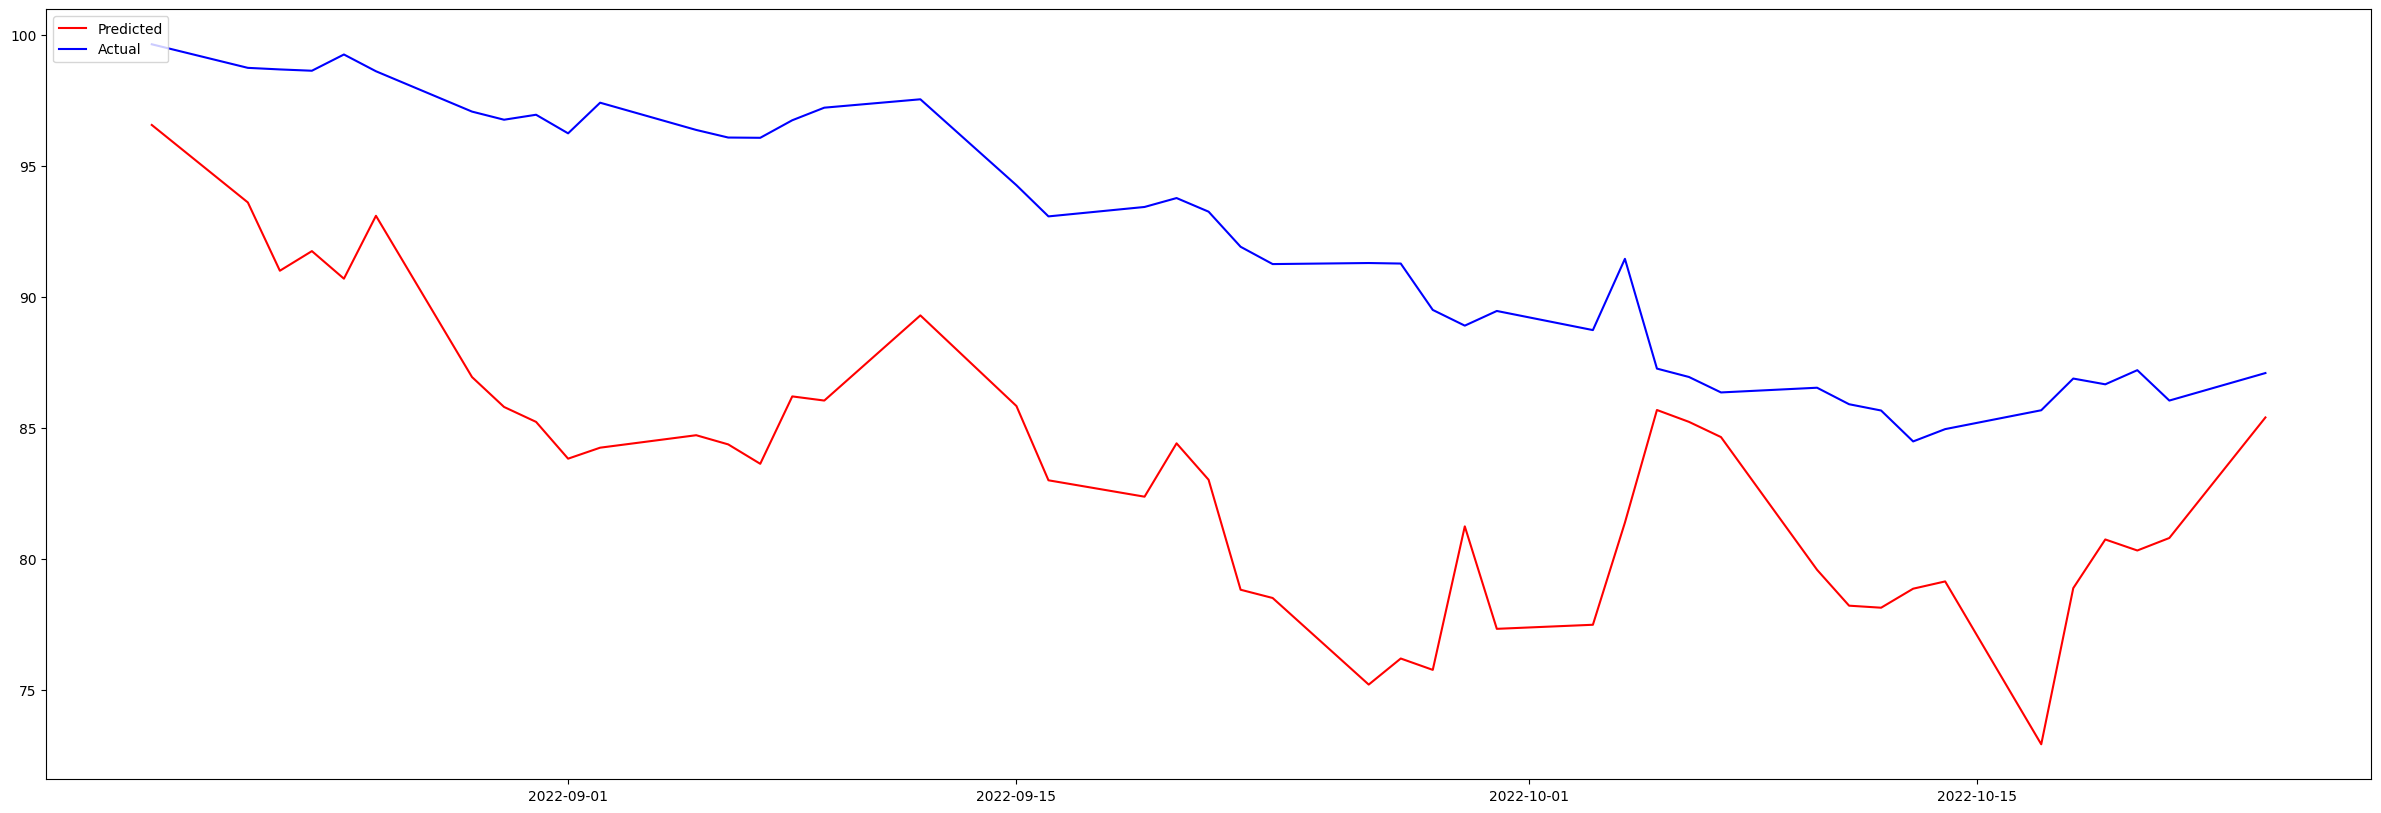

In [2]:
experiment_details = {
    'Nsim': 2500,
    'latest_price_date': '2022-10-24',
    'variance_reduction': 'CV',
    'GBM': 'multivariate',
    'r': 0.045
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

# def EMS(SimPaths,Deltat,r):
#     Nsim,m = SimPaths.shape
#     m-=1
#     S = np.zeros((Nsim,m+1))
#     Z = np.zeros((Nsim+1,m))
#     # print(SimPaths[:,0:1])
#     S[:,0:1] = SimPaths[:,0:1]
#     # print(S[:,0:1])


#     for j in range(1,m+1):
#         Z[0:Nsim,j-1:j] = S[:,j-1:j]*SimPaths[:,j:j+1]/SimPaths[:,j-1:j]
#         Z[Nsim:Nsim+1,j-1:j]=np.exp(-r*((j-1)*Deltat))*np.mean(Z[0:Nsim,j-1:j])
#         S[:,j:j+1] = SimPaths[:,0:1]*Z[0:Nsim,j-1:j]/Z[Nsim:Nsim+1,j-1:j]
#     # print(S)
#     return S


date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

predicted_option_price = []
expected_payoff_maturity = []
# counter = 0

while date_to_predict <= end_date:
    # if counter == 5:
    #     break

    if date_to_predict in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date'])
    n0 = len(AAG)
    dates = AAG['Date']
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    sigma = np.cov(AAGlogreturns, rowvar=False)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r']
    print(f"trading_days_to_simulate: {trading_days_to_simulate}")
    # print(f"m: {m}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    for i in range(1, Nsim + 1):
        S = SimMultiGBMCV(S0, v, sigma, dt, T)
        sim_aapl.append(S[0])
        sim_amzn.append(S[1])
        sim_googl.append(S[2])

    # sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
    # sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
    # sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []

    for i in range(Nsim):
        option_prices.append(
            calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                r=r,
                q2_index=q2_index,
                q3_index=q3_index
            )
        )

    option_price = np.mean(option_prices)
    expected_payoff_maturity.append(option_price)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    # cur_expected_payoff = np.mean(payoff_maturity)
    # expected_payoff_maturity.append(cur_expected_payoff)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    # counter+=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/derivative_01_11_22.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], experiment_details)

# Estimating Implied Volatility

In [8]:
min_sigma = 1
max_sigma = 10*100
error = 1
sigma_hat_list = [x/100 for x in range(min_sigma,max_sigma+error,error)]
print(sigma_hat_list)
right = len(sigma_hat_list)
left = 0 
IV = estimate_IV(102.09,220.10,120,0.0475,218,sigma_hat_list,left,right,error)
print(IV)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1